<a href="https://colab.research.google.com/github/LolitaOnayeva/Detecting-Mental-Health-Conditions-on-Reddit-using-NLP-and-machine-learning-/blob/main/WD_C%3D1_HingeLoss_Mental_Health_Unigram_Tfidf_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv                               
import re                                       
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support 
from random import shuffle
import numpy as np
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import hamming_loss, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def parseReview(reviewLine): 
    Mental_Health_Condition=reviewLine[4]
    Post=reviewLine[7] 

    return (Mental_Health_Condition,Post)

In [ ]:
def preProcess(text):
    
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) 
    text = re.sub(r"([.,;:!?'\"“\(])(\w)", r"\1 \2", text)
    text = re.sub(r"(\S)\1\1+",r"\1\1\1", text)
    text = re.sub(r'[^A-Za-z0-9 ]+','', text)  # remove non- english characters such as Äö 
    
    # normalisation- convert to lower case 
    tokens = text.split(" ")
    tokens = [t.lower() for t in tokens]
    
    porter = PorterStemmer()
    stemmed_tokens = []
    for token in tokens:
        stemmed_tokens.append(porter.stem(token))
        
    lemmatized_tokens=[]
    lemmatizer = WordNetLemmatizer()
    for token in stemmed_tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(token))
    
    return lemmatized_tokens

In [ ]:
featureDict = {} 

def toFeatureVector(lemmatized_tokens):
    v = {}
    for t in lemmatized_tokens:
        try:
            featureDict[t] += 1
        except KeyError:            
            featureDict[t] = 1
        try:
            v[t] += (1.0/len(lemmatized_tokens))
        except KeyError:
            v[t] = (1.0/len(lemmatized_tokens))
    return v

In [ ]:
# Downloading datasets 
rawTrainData=[]
with open("/content/drive/MyDrive/mental_health_data/without_depression_df_train.csv") as f:
    reader = csv.reader(f,quoting=csv.QUOTE_ALL, skipinitialspace=True)
    for line in reader:   
        (Mental_Health_Condition,Post) = parseReview(line)
        rawTrainData.append((Mental_Health_Condition,Post))
        
rawTestData=[]
with open('/content/drive/MyDrive/mental_health_data/without_depression_df_test.csv') as f:
    reader = csv.reader(f,quoting=csv.QUOTE_ALL, skipinitialspace=True)
    for line in reader:   
        (Mental_Health_Condition,Post) = parseReview(line)
        rawTestData.append((Mental_Health_Condition,Post))

testData=[]
trainData=[]

for (Mental_Health_Condition,Post) in rawTrainData:
        #trainData.append((Mental_Health_Condition,toFeatureVector(preProcess(Post))))
        trainData.append((toFeatureVector(preProcess(Post)),Mental_Health_Condition))

for (Mental_Health_Condition,Post) in rawTestData:
        #testData.append((Mental_Health_Condition,toFeatureVector(preProcess(Post))))
        testData.append((toFeatureVector(preProcess(Post)),Mental_Health_Condition))

In [ ]:
testData[5]

({'': 0.11029411764705883,
  '3rd': 0.007352941176470588,
  '4': 0.007352941176470588,
  '9': 0.007352941176470588,
  'a': 0.014705882352941176,
  'again': 0.007352941176470588,
  'and': 0.029411764705882353,
  'anyon': 0.007352941176470588,
  'are': 0.007352941176470588,
  'ativan': 0.007352941176470588,
  'away': 0.007352941176470588,
  'back': 0.007352941176470588,
  'been': 0.022058823529411763,
  'better': 0.007352941176470588,
  'but': 0.014705882352941176,
  'call': 0.007352941176470588,
  'chest': 0.029411764705882353,
  'close': 0.007352941176470588,
  'come': 0.007352941176470588,
  'current': 0.007352941176470588,
  'day': 0.007352941176470588,
  'discomfort': 0.007352941176470588,
  'doctor': 0.007352941176470588,
  'el': 0.007352941176470588,
  'episod': 0.007352941176470588,
  'er': 0.007352941176470588,
  'everyth': 0.007352941176470588,
  'feel': 0.014705882352941176,
  'felt': 0.007352941176470588,
  'fine': 0.007352941176470588,
  'for': 0.014705882352941176,
  'gave'

In [ ]:
# Lenght of the datasets
print("Now  %d trainData, %d testData" % ( len(trainData), len(testData)))

# Number of features
print("Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')

Now  75914 trainData, 18963 testData
Training Samples: 
75914
Features: 
117287


In [ ]:
# Training and validating classifier
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline = Pipeline([('tfidf', TfidfTransformer()),('svc', LinearSVC(penalty='l2', loss='hinge', dual=True, tol=0.0001, C=1, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None))])
    return SklearnClassifier(pipeline).train(trainData)



In [ ]:
# Predicting labels given a classifier
def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

In [ ]:
# Cross-Validate
def crossValidate(dataset, folds):
    shuffle(dataset)
    results = []
    foldSize = int(len(dataset)/folds)
    
    for i in range(0,len(dataset),int(foldSize)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+foldSize))
        myTestData = dataset[i:i+foldSize]
        myTrainData = dataset[:i] + dataset[i+foldSize:]
        classifier = trainClassifier(myTrainData)
        y_true = [x[1] for x in myTestData]
        y_pred = predictLabels(myTestData, classifier)
        results.append(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
        
    print(zip(*results))
    avgResults = [np.mean([x[0] for x in results]),
                  np.mean([x[1] for x in results]),
                  np.mean([x[2] for x in results])
                ]
    return avgResults

In [ ]:
cv_results = crossValidate(trainData, 10)
print(cv_results)

Fold start on items 0 - 7591
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 7591 - 15182
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 15182 - 22773
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 22773 - 30364
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 30364 - 37955
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 37955 - 45546
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 45546 - 53137
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 53137 - 60728
Training Classifier...
Fold start on items 60728 - 68319
Training Classifier...
Fold start on items 68319 - 75910
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 75910 - 83501
Training Classifier...
[0.9205879671633959, 0.8985311553155053, 0.9041066122786545]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
functions_complete = True  
if functions_complete:
    print(testData[0])   
    classifier = trainClassifier(trainData)  
    testTrue = [t[1] for t in testData]   
    testPred = predictLabels(testData, classifier)  
    finalScores = precision_recall_fscore_support(testTrue, testPred, average='weighted')
    #accuracy_score 
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % finalScores[:3])
    print("accuracy_score:", accuracy_score(testTrue, testPred))

({'some': 0.007547169811320755, 'advic': 0.01509433962264151, 'for': 0.02641509433962264, 'my': 0.01509433962264151, 'friend': 0.0037735849056603774, 'plea': 0.0037735849056603774, '': 0.11698113207547169, 'i': 0.02641509433962264, 'date': 0.0037735849056603774, 'thi': 0.0037735849056603774, 'girl': 0.0037735849056603774, 'about': 0.007547169811320755, 'a': 0.030188679245283016, 'year': 0.007547169811320755, 'befor': 0.0037735849056603774, 'she': 0.022641509433962263, 'move': 0.0037735849056603774, 'away': 0.0037735849056603774, 'temporarili': 0.0037735849056603774, 'servic': 0.0037735849056603774, 'opportun': 0.0037735849056603774, 'been': 0.018867924528301886, 'gone': 0.0037735849056603774, 'few': 0.0037735849056603774, 'month': 0.0037735849056603774, 'now': 0.0037735849056603774, 'left': 0.0037735849056603774, 'on': 0.0037735849056603774, 'the': 0.011320754716981133, 'trip': 0.0037735849056603774, 'and': 0.007547169811320755, 'weve': 0.0037735849056603774, 'commun': 0.00377358490566

In [ ]:
print(metrics.classification_report(testTrue, testPred))

                 precision    recall  f1-score   support

        anxiety       0.89      0.89      0.89      4362
  bipolarreddit       0.87      0.58      0.70       325
     conspiracy       0.91      0.93      0.92      1502
        fitness       0.97      0.98      0.98      3456
     meditation       0.95      0.91      0.93       961
      parenting       0.92      0.95      0.93      1918
personalfinance       0.92      0.90      0.91       308
           ptsd       0.88      0.61      0.73       438
  schizophrenia       0.84      0.62      0.72       486
   suicidewatch       0.89      0.95      0.92      4930
       teaching       0.88      0.82      0.85       277

       accuracy                           0.91     18963
      macro avg       0.90      0.83      0.86     18963
   weighted avg       0.91      0.91      0.91     18963



In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
labels=['bipolarreddit','fitness','meditation','conspiracy','anxiety','parenting',
        'personalfinance','schizophrenia','suicidewatch','teaching','ptsd']
confusion = confusion_matrix(testTrue, testPred,labels)

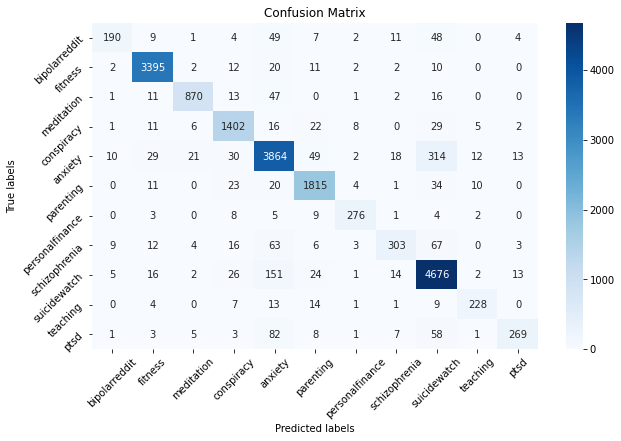

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels( labels,rotation=45); ax.set_yticklabels(labels,rotation=45);